<a href="https://colab.research.google.com/github/SreenidhiCodes/ml-stock-analyzer/blob/main/main_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Available Companies:
AAPL → Apple
MSFT → Microsoft
GOOGL → Alphabet (Google)
AMZN → Amazon
META → Meta Platforms
TSLA → Tesla
NVDA → NVIDIA
JPM → JPMorgan Chase
V → Visa
MA → MasterCard
NFLX → Netflix
DIS → Disney
PYPL → PayPal
PEP → PepsiCo
KO → Coca-Cola

Enter the stock code (example: AAPL for Apple): V


/tmp/ipython-input-3713462882.py:40: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(ticker, start="2020-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


 You selected Visa (V)
                 Close
Date                  
2020-01-02  183.549088
2020-01-03  182.089340
2020-01-06  181.695526
2020-01-07  181.215332
2020-01-08  184.317383

 Strategy Performance
CAGR: -0.76%
Sharpe Ratio: 0.04
Max Drawdown: 31.19%



/tmp/ipython-input-3713462882.py:111: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(code, start="2020-01-01", end="2025-01-01")["Close"]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3713462882.py:111: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(code, start="2020-01-01", end="2025-01-01")["Close"]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3713462882.py:111: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(code, start="2020-01-01", end="2025-01-01")["Close"]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3713462882.py:111: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(code, start="2020-01-01", end="2025-01-01")["Close"]
[*********************100%******


 Performance of All Companies (2020–2025):
                   Gain/Loss %
Apple                   244.00
Microsoft               174.36
Alphabet (Google)       177.62
Amazon                  131.18
Meta Platforms          180.17
Tesla                  1307.89
NVIDIA                 2148.39
JPMorgan Chase           96.32
Visa                     71.31
MasterCard               78.48
Netflix                 170.25
Disney                  -23.94
PayPal                  -22.93
PepsiCo                  29.27
Coca-Cola                32.20

💾 Results saved as comparison_results_2025.csv


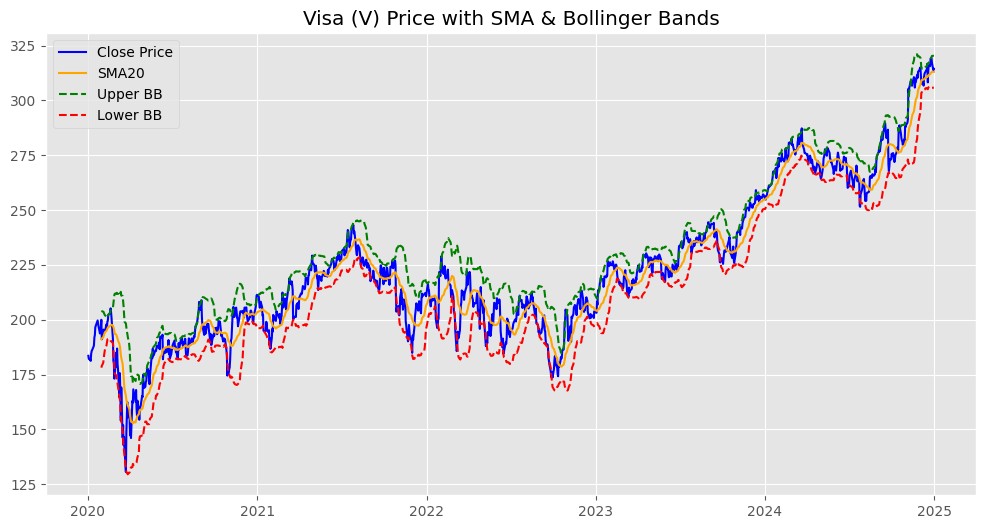

In [7]:

# Stock Analysis Project
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Company List for Users

companies = {
    "AAPL": "Apple",
    "MSFT": "Microsoft",
    "GOOGL": "Alphabet (Google)",
    "AMZN": "Amazon",
    "META": "Meta Platforms",
    "TSLA": "Tesla",
    "NVDA": "NVIDIA",
    "JPM": "JPMorgan Chase",
    "V": "Visa",
    "MA": "MasterCard",
    "NFLX": "Netflix",
    "DIS": "Disney",
    "PYPL": "PayPal",
    "PEP": "PepsiCo",
    "KO": "Coca-Cola"
}

print(" Available Companies:")
for k, v in companies.items():
    print(f"{k} → {v}")

ticker = input("\nEnter the stock code (example: AAPL for Apple): ").strip().upper()

if ticker not in companies:
    raise ValueError(" Invalid ticker. Please select from the list above.")

print(f"\n You selected {companies[ticker]} ({ticker})")

# Step 2: Download Stock Data

raw = yf.download(ticker, start="2020-01-01", end="2025-01-01")

# Handle MultiIndex safely
if isinstance(raw.columns, pd.MultiIndex):
    if ("Close", ticker) in raw.columns:
        close = raw[("Close", ticker)]
    else:
        close = raw["Close"].iloc[:, 0]
else:
    close = raw["Close"]

# Flatten to 1D
if isinstance(close, pd.DataFrame):
    close = close.squeeze()

#  Build a fresh DataFrame so "Close" always exists
df = pd.DataFrame(index=raw.index)
df["Close"] = pd.to_numeric(close, errors="coerce")

#  Drop missing rows safely
df.dropna(inplace=True)

print(df.head())

# Step 3: Technical Indicators

df["SMA20"] = df["Close"].rolling(window=20).mean()
df["EMA20"] = df["Close"].ewm(span=20, adjust=False).mean()

# RSI
delta = df["Close"].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain.flatten(), index=df.index).rolling(window=14).mean()
avg_loss = pd.Series(loss.flatten(), index=df.index).rolling(window=14).mean()
rs = avg_gain / avg_loss
df["RSI"] = 100 - (100 / (1 + rs))

# MACD
df["EMA12"] = df["Close"].ewm(span=12, adjust=False).mean()
df["EMA26"] = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"] = df["EMA12"] - df["EMA26"]
df["Signal_Line"] = df["MACD"].ewm(span=9, adjust=False).mean()

# Bollinger Bands
rolling_std = df["Close"].rolling(window=20).std(ddof=0)
df["Bollinger_Upper"] = df["SMA20"] + 2 * rolling_std
df["Bollinger_Lower"] = df["SMA20"] - 2 * rolling_std

# Step 4: Strategy Backtest

df["Signal"] = np.where(df["Close"] > df["SMA20"], 1, 0)
df["Return"] = df["Close"].pct_change()
df["Strategy_Return"] = df["Signal"].shift(1) * df["Return"]

# Performance Metrics
cagr = (df["Strategy_Return"] + 1).prod() ** (252 / len(df)) - 1
sharpe = df["Strategy_Return"].mean() / df["Strategy_Return"].std() * np.sqrt(252)
cum_returns = (1 + df["Strategy_Return"]).cumprod()
max_dd = (cum_returns.cummax() - cum_returns).max()

print("\n Strategy Performance")
print(f"CAGR: {cagr:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_dd:.2%}")


# Step 5: Compare All Companies Till 2025

comparison = {}
for code, name in companies.items():
    data = yf.download(code, start="2020-01-01", end="2025-01-01")["Close"]
    if isinstance(data, pd.DataFrame):
        data = data.iloc[:, 0]
    data = pd.to_numeric(data, errors="coerce").dropna()
    if len(data) > 0:
        gain = (data.iloc[-1] - data.iloc[0]) / data.iloc[0] * 100
        comparison[name] = round(gain, 2)

comparison_df = pd.DataFrame.from_dict(comparison, orient="index", columns=["Gain/Loss %"])
print("\n Performance of All Companies (2020–2025):")
print(comparison_df)

# Save CSV
comparison_df.to_csv("comparison_results_2025.csv")
print("\n💾 Results saved as comparison_results_2025.csv")

# Step 6: Plot Closing Price + SMA + Bollinger Bands

plt.figure(figsize=(12,6))
plt.plot(df.index, df["Close"], label="Close Price", color="blue")
plt.plot(df.index, df["SMA20"], label="SMA20", color="orange")
plt.plot(df.index, df["Bollinger_Upper"], label="Upper BB", color="green", linestyle="--")
plt.plot(df.index, df["Bollinger_Lower"], label="Lower BB", color="red", linestyle="--")
plt.legend()
plt.title(f"{companies[ticker]} ({ticker}) Price with SMA & Bollinger Bands")
plt.show()
